In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pywt
import urllib.request
import zipfile
import os
import optuna
from optuna.samplers import TPESampler
from functools import partial
from scipy.io import arff

from aux_functions import timeseries_to_pandas
from aux_functions import pandas_to_numpy
import seaborn as sns

# Configurações
plt.style.use('ggplot')
np.random.seed(42)

c:\Users\User\anaconda3\envs\PHD\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# pip install pywavelets

## Tratamento inicial dos dados

In [3]:
#Read data
data_train = {}
data_test = {}

for i in range(1,7):
    data_train[i] = arff.loadarff(os.path.join('SelfRegulationSCP1',
                                               f'SelfRegulationSCP1Dimension{i}_TRAIN.arff'))[0]
    data_test[i] = arff.loadarff(os.path.join('SelfRegulationSCP1',
                                               f'SelfRegulationSCP1Dimension{i}_TEST.arff'))[0]
    
#Convert to pandas dataframes
df_train = timeseries_to_pandas(data_train)
df_test = timeseries_to_pandas(data_test)

#Convert to numpy arrays
X_train, y_train = pandas_to_numpy(df_train)
X_test, y_test = pandas_to_numpy(df_test)



# Convertendo de bytes para string
y_train = np.array([y.decode('utf-8') if isinstance(y, bytes) else y for y in y_train])
y_test = np.array([y.decode('utf-8') if isinstance(y, bytes) else y for y in y_test])

label_map = {'negativity': 0, 'positivity': 1}

y_train = np.array([label_map[y] for y in y_train])
y_test = np.array([label_map[y] for y in y_test])


#Create folder structure and save the arrays
if not os.path.exists(os.path.join('Datasets_clean', 'SelfRegulationSCP1')):
    os.makedirs(os.path.join('Datasets_clean', 'SelfRegulationSCP1'))

np.save('Datasets_clean/SelfRegulationSCP1/X_train', X_train)
np.save('Datasets_clean/SelfRegulationSCP1/y_train', y_train)
np.save('Datasets_clean/SelfRegulationSCP1/X_test', X_test)
np.save('Datasets_clean/SelfRegulationSCP1/y_test', y_test)

## Leitura dos  dados processados

In [3]:
X_train = np.load('Datasets_clean/SelfRegulationSCP1/X_train.npy')
y_train = np.load('Datasets_clean/SelfRegulationSCP1/y_train.npy')  
X_test = np.load('Datasets_clean/SelfRegulationSCP1/X_test.npy')    
y_test = np.load('Datasets_clean/SelfRegulationSCP1/y_test.npy')

## Fast Wavelet Transform

In [4]:
# --- Função para extrair features Wavelet 1D (coeficientes e estatísticas simples) ---
def extract_wavelet_features(X, wavelet='db4', level=3):
    """
    Extrai features baseadas na decomposição Wavelet dos sinais.

    Parâmetros:
    - X: array numpy de formato (n_amostras, n_canais, n_tempo)
    - wavelet: tipo de wavelet (ex.: 'db4')
    - level: nível de decomposição

    Retorna:
    - features: array (n_amostras, n_features)
    - feature_names: lista de nomes das features
    """
    dimension_names = ['Canal1_Fp1', 'Canal2_Fp2', 'Canal3_Cz', 
                        'Canal4_Pz', 'Canal5_O1', 'Canal6_O2']
    
    features = []
    feature_names = []

    for i in range(X.shape[0]):  # para cada amostra
        sample_features = []

        for dim in range(X.shape[1]):  # para cada dimensão (canal EEG)
            coeffs = pywt.wavedec(X[i, dim, :], wavelet, level=level)

            for j, coef in enumerate(coeffs):
                # estatísticas básicas dos coeficientes
                sample_features.append(np.mean(coef))
                sample_features.append(np.std(coef))
                sample_features.append(np.median(coef))
                sample_features.append(np.max(coef))
                sample_features.append(np.min(coef))

                # apenas uma vez, monta os nomes das features
                if i == 0:
                    base_name = f'{dimension_names[dim]}_coef{j}_'
                    feature_names += [
                        base_name + stat for stat in ['mean', 'std', 'median', 'max', 'min']
                    ]

        features.append(sample_features)

    return np.array(features), feature_names


In [5]:
X_train_feat, feature_names = extract_wavelet_features(X_train)
X_test_feat, _ = extract_wavelet_features(X_test)

## Pipeline de modelos e otimização com Optuna

In [51]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, recall_score, precision_score


# Função de otimização
def objective(trial, model_name):
    if model_name == 'random_forest':
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        max_depth = trial.suggest_int('max_depth', 3, 20)
        clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)

    elif model_name == 'lightgbm':
        num_leaves = trial.suggest_int('num_leaves', 15, 100)
        learning_rate = trial.suggest_float('learning_rate', 1e-3, 0.3, log=True)
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        clf = LGBMClassifier(num_leaves=num_leaves, learning_rate=learning_rate,
                             n_estimators=n_estimators, random_state=42)

    elif model_name == 'xgboost':
        max_depth = trial.suggest_int('max_depth', 3, 15)
        learning_rate = trial.suggest_float('learning_rate', 1e-3, 0.3, log=True)
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        clf = XGBClassifier(max_depth=max_depth, learning_rate=learning_rate,
                            n_estimators=n_estimators, use_label_encoder=False,
                            eval_metric='logloss', random_state=42)

    elif model_name == 'svm':
        C = trial.suggest_float('C', 1e-3, 100, log=True)
        gamma = trial.suggest_float('gamma', 1e-4, 1, log=True)
        clf = SVC(C=C, gamma=gamma, probability=True, random_state=42)

    elif model_name == 'logistic_regression':
        C = trial.suggest_float('C', 1e-4, 100, log=True)
        penalty = trial.suggest_categorical('penalty', ['l2'])
        clf = LogisticRegression(C=C, penalty=penalty, max_iter=1000, random_state=42)

    else:
        raise ValueError('Unknown model')

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_train_feat, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)

    # Armazena desvio padrão no trial.user_attrs
    trial.set_user_attr("std_f1", np.std(scores))

    return np.mean(scores)


## Otimização para todos os modelos

In [52]:
models = ['random_forest', 'lightgbm', 'xgboost', 'svm', 'logistic_regression']
best_models = {}
studies = {}
results = []

sampler = TPESampler(seed=42)

for model in models:
    print(f'Optimizing {model}...')
    study = optuna.create_study(direction='maximize', sampler=sampler)
    study.optimize(lambda trial: objective(trial, model), n_trials=100, n_jobs=-1)

    print(f'Best params for {model}: {study.best_params}')
    best_models[model] = study.best_params
    studies[model] = study

    for t in study.trials:
        results.append({
            'model': model,
            'trial': t.number,
            'value_mean': t.value,
            'value_std': t.user_attrs.get("std_f1")
        })

df_results = pd.DataFrame(results)
print(df_results)


[I 2025-06-01 02:21:57,149] A new study created in memory with name: no-name-a74d206a-5d68-4a73-92a4-3d1e20027a73


Optimizing random_forest...


[I 2025-06-01 02:22:04,564] Trial 2 finished with value: 0.8054274739680227 and parameters: {'n_estimators': 263, 'max_depth': 15}. Best is trial 2 with value: 0.8054274739680227.
[I 2025-06-01 02:22:06,798] Trial 0 finished with value: 0.8128916240736823 and parameters: {'n_estimators': 291, 'max_depth': 15}. Best is trial 0 with value: 0.8128916240736823.
[I 2025-06-01 02:22:08,099] Trial 3 finished with value: 0.8166974622524397 and parameters: {'n_estimators': 113, 'max_depth': 18}. Best is trial 3 with value: 0.8166974622524397.
[I 2025-06-01 02:22:08,112] Trial 1 finished with value: 0.8049909100071403 and parameters: {'n_estimators': 168, 'max_depth': 5}. Best is trial 3 with value: 0.8166974622524397.
[I 2025-06-01 02:22:08,425] Trial 4 finished with value: 0.8131067739412268 and parameters: {'n_estimators': 62, 'max_depth': 8}. Best is trial 3 with value: 0.8166974622524397.
[I 2025-06-01 02:22:10,823] Trial 5 finished with value: 0.8093778477819601 and parameters: {'n_estimat

Best params for random_forest: {'n_estimators': 87, 'max_depth': 7}
Optimizing lightgbm...


[I 2025-06-01 02:24:19,583] Trial 0 finished with value: 0.8166447928578726 and parameters: {'num_leaves': 83, 'learning_rate': 0.0067207567243469865, 'n_estimators': 268}. Best is trial 0 with value: 0.8166447928578726.
[I 2025-06-01 02:24:20,207] Trial 1 finished with value: 0.8092884149815045 and parameters: {'num_leaves': 84, 'learning_rate': 0.20237896402735583, 'n_estimators': 296}. Best is trial 0 with value: 0.8166447928578726.
[I 2025-06-01 02:24:20,574] Trial 2 finished with value: 0.7934130114011305 and parameters: {'num_leaves': 23, 'learning_rate': 0.003791664305656686, 'n_estimators': 74}. Best is trial 0 with value: 0.8166447928578726.
[I 2025-06-01 02:24:21,245] Trial 3 finished with value: 0.8279141229141229 and parameters: {'num_leaves': 19, 'learning_rate': 0.056441352971575556, 'n_estimators': 101}. Best is trial 3 with value: 0.8279141229141229.
[I 2025-06-01 02:24:22,897] Trial 4 finished with value: 0.790226649066342 and parameters: {'num_leaves': 51, 'learning_r

Best params for lightgbm: {'num_leaves': 56, 'learning_rate': 0.03753295526400347, 'n_estimators': 52}
Optimizing xgboost...


[I 2025-06-01 02:25:46,248] Trial 1 finished with value: 0.8388632963480459 and parameters: {'max_depth': 8, 'learning_rate': 0.17194191028077127, 'n_estimators': 197}. Best is trial 1 with value: 0.8388632963480459.
[I 2025-06-01 02:25:46,593] Trial 0 finished with value: 0.8349372576853537 and parameters: {'max_depth': 10, 'learning_rate': 0.11481180570104016, 'n_estimators': 228}. Best is trial 1 with value: 0.8388632963480459.
[I 2025-06-01 02:25:48,899] Trial 3 finished with value: 0.7935977246716895 and parameters: {'max_depth': 13, 'learning_rate': 0.008935121294898712, 'n_estimators': 57}. Best is trial 1 with value: 0.8388632963480459.
[I 2025-06-01 02:25:48,998] Trial 2 finished with value: 0.8353281624036342 and parameters: {'max_depth': 3, 'learning_rate': 0.15708453781820553, 'n_estimators': 112}. Best is trial 1 with value: 0.8388632963480459.
[I 2025-06-01 02:25:58,043] Trial 5 finished with value: 0.8350128362203835 and parameters: {'max_depth': 10, 'learning_rate': 0.1

Best params for xgboost: {'max_depth': 6, 'learning_rate': 0.03557297177098066, 'n_estimators': 164}
Optimizing svm...


[I 2025-06-01 02:31:31,715] Trial 1 finished with value: 0.33499999999999996 and parameters: {'C': 34.54521657991774, 'gamma': 0.20255945956285615}. Best is trial 1 with value: 0.33499999999999996.
[I 2025-06-01 02:31:31,797] Trial 0 finished with value: 0.33499999999999996 and parameters: {'C': 0.01522457034252639, 'gamma': 0.0007880207605321138}. Best is trial 1 with value: 0.33499999999999996.
[I 2025-06-01 02:31:31,914] Trial 2 finished with value: 0.33499999999999996 and parameters: {'C': 0.012042807708407485, 'gamma': 0.040295254481987015}. Best is trial 1 with value: 0.33499999999999996.
[I 2025-06-01 02:31:31,985] Trial 3 finished with value: 0.33499999999999996 and parameters: {'C': 0.2128396522453822, 'gamma': 0.000804923853174109}. Best is trial 1 with value: 0.33499999999999996.
[I 2025-06-01 02:31:32,159] Trial 4 finished with value: 0.33499999999999996 and parameters: {'C': 1.3093409257063953, 'gamma': 0.5035457227934164}. Best is trial 1 with value: 0.33499999999999996.


Best params for svm: {'C': 2.847909314106284, 'gamma': 0.00010225716984526353}
Optimizing logistic_regression...


[I 2025-06-01 02:31:46,077] Trial 2 finished with value: 0.7258251822998082 and parameters: {'C': 36.81173247778265, 'penalty': 'l2'}. Best is trial 2 with value: 0.7258251822998082.
[I 2025-06-01 02:31:46,678] Trial 0 finished with value: 0.7149583477674192 and parameters: {'C': 70.12438772852276, 'penalty': 'l2'}. Best is trial 2 with value: 0.7258251822998082.
[I 2025-06-01 02:31:46,955] Trial 1 finished with value: 0.7757146796140827 and parameters: {'C': 0.006012444758599495, 'penalty': 'l2'}. Best is trial 1 with value: 0.7757146796140827.
[I 2025-06-01 02:31:47,732] Trial 3 finished with value: 0.7529690309690309 and parameters: {'C': 0.406772310192761, 'penalty': 'l2'}. Best is trial 1 with value: 0.7757146796140827.
[I 2025-06-01 02:31:47,946] Trial 4 finished with value: 0.7831541934860471 and parameters: {'C': 0.0021974826566759993, 'penalty': 'l2'}. Best is trial 4 with value: 0.7831541934860471.
[I 2025-06-01 02:31:48,993] Trial 5 finished with value: 0.7871892987597761 an

Best params for logistic_regression: {'C': 0.00012969532071705365, 'penalty': 'l2'}
                   model  trial  value_mean  value_std
0          random_forest      0    0.812892   0.032163
1          random_forest      1    0.804991   0.050848
2          random_forest      2    0.805427   0.031435
3          random_forest      3    0.816697   0.039035
4          random_forest      4    0.813107   0.020368
..                   ...    ...         ...        ...
495  logistic_regression     95    0.790143   0.048185
496  logistic_regression     96    0.790143   0.048185
497  logistic_regression     97    0.786104   0.055814
498  logistic_regression     98    0.782425   0.065806
499  logistic_regression     99    0.782425   0.065806

[500 rows x 4 columns]


In [53]:
df_results.head()

,model,trial,value_mean,value_std
0,random_forest,0,0.812892,0.032163
1,random_forest,1,0.804991,0.050848
2,random_forest,2,0.805427,0.031435
3,random_forest,3,0.816697,0.039035
4,random_forest,4,0.813107,0.020368


In [54]:
df_results.to_csv('results_selfregulation.csv', index=False)

In [55]:
# Mapeamento dos nomes dos modelos
model_name_map = {
    'random_forest': 'RF',
    'lightgbm': 'LGBM',
    'xgboost': 'XGB',
    'svm': 'SVM',
    'logistic_regression': 'LR'
}

# Aplica o mapeamento no dataframe
df_results["model_short"] = df_results["model"].map(model_name_map)


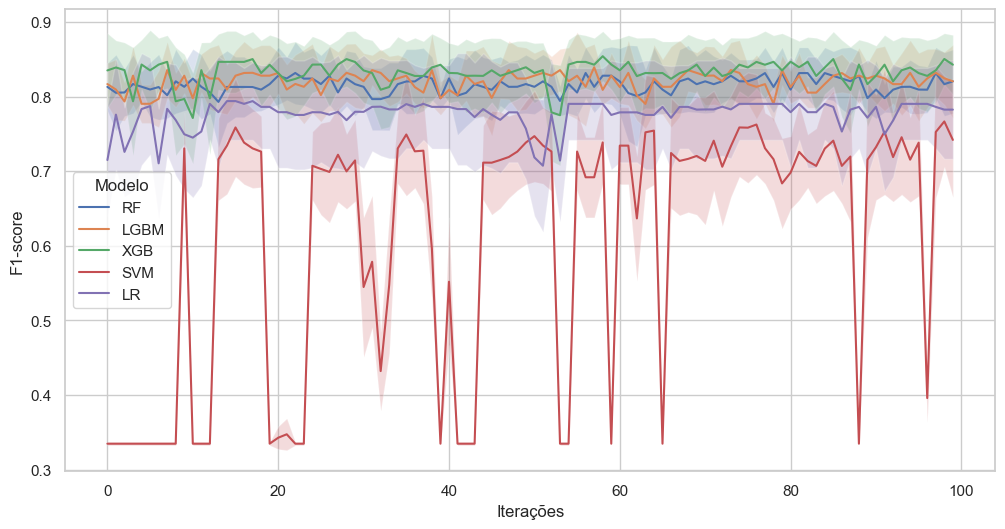

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_results, 
    x="trial", 
    y="value_mean", 
    hue="model_short", 
    # marker="o"
)

for model in df_results["model_short"].unique():
    subset = df_results[df_results["model_short"] == model]
    plt.fill_between(
        subset["trial"],
        subset["value_mean"] - subset["value_std"],
        subset["value_mean"] + subset["value_std"],
        alpha=0.2
    )

# plt.title("Desempenho dos Modelos ao longo das Interações (F1-Macro)")
plt.xlabel("Iterações")
plt.ylabel("F1-score")
plt.legend(title="Modelo")
plt.grid(True)

## Avaliação Final

In [58]:
models = ['random_forest', 'lightgbm', 'xgboost', 'svm', 'logistic_regression']
model_names = {'random_forest': 'RF', 'lightgbm': 'LGBM', 'xgboost': 'XGB', 'svm': 'SVM', 'logistic_regression': 'LR'}


In [61]:
import os
import pickle
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, roc_auc_score
import pandas as pd

os.makedirs('models', exist_ok=True)

# Função para instanciar o modelo com os melhores hiperparâmetros
def train_best_model(model_name, params):
    if model_name == 'random_forest':
        model = RandomForestClassifier(**params, random_state=42)
    elif model_name == 'lightgbm':
        model = LGBMClassifier(**params, random_state=42)
    elif model_name == 'xgboost':
        model = XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss', random_state=42)
    elif model_name == 'svm':
        model = SVC(**params, probability=True, random_state=42)
    elif model_name == 'logistic_regression':
        model = LogisticRegression(**params, max_iter=1000, random_state=42)
    else:
        raise ValueError('Unknown model')
    return model


# Renomeação dos modelos para o formato desejado nos arquivos e resultados
model_names_map = {
    'random_forest': 'RF',
    'lightgbm': 'LGBM',
    'xgboost': 'XGB',
    'svm': 'SVM',
    'logistic_regression': 'LR'
}

results = []

# Loop para treinamento, salvamento e avaliação dos modelos
for model_name, params in best_models.items():
    print(f'Training {model_name} with best hyperparameters...')

    model = train_best_model(model_name, params)
    model.fit(X_train_feat, y_train)

    filename = f'models/{model_names_map[model_name]}_model.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

    print(f'Modelo {model_names_map[model_name]} salvo em {filename}')

    y_pred = model.predict(X_test_feat)
    y_proba = model.predict_proba(X_test_feat)[:, 1] if hasattr(model, "predict_proba") else None

    metrics = {
        'Model': model_names_map[model_name],
        'F1_Score': f1_score(y_test, y_pred, average='macro'),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred, average='macro'),
        'Precision': precision_score(y_test, y_pred, average='macro'),
        'ROC_AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else None
    }
    results.append(metrics)

df_results = pd.DataFrame(results)
print(df_results)


Training random_forest with best hyperparameters...
Modelo RF salvo em models/RF_model.pkl
Training lightgbm with best hyperparameters...
[LightGBM] [Info] Number of positive: 133, number of negative: 135
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10808
[LightGBM] [Info] Number of data points in the train set: 268, number of used features: 120
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496269 -> initscore=-0.014926
[LightGBM] [Info] Start training from score -0.014926
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [62]:
df_results

,Model,F1_Score,Accuracy,Recall,Precision,ROC_AUC
0,RF,0.757403,0.767918,0.768638,0.826103,0.888640
1,LGBM,0.727188,0.740614,0.741380,0.801683,0.881931
2,XGB,0.759442,0.767918,0.768568,0.813568,0.858960
3,SVM,0.766720,0.767918,0.768172,0.774071,0.844003
4,LR,0.782807,0.788396,0.788953,0.822894,0.898938


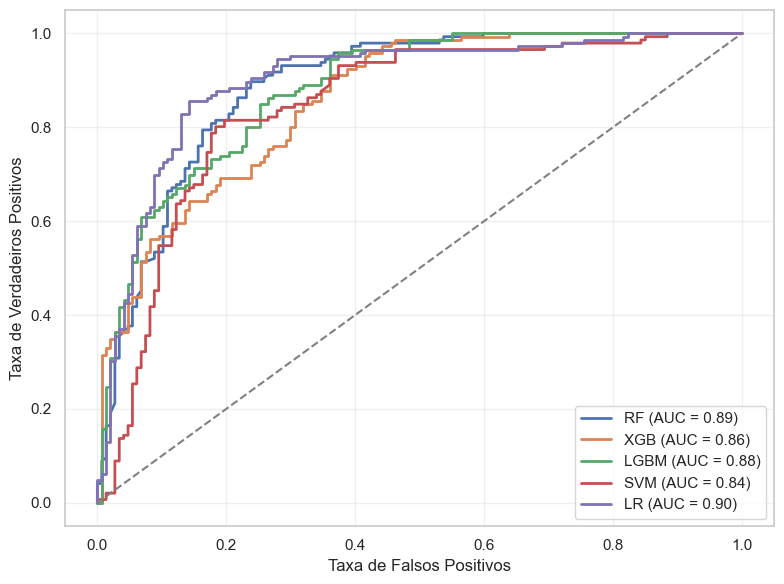

In [ ]:
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# Mapear os nomes dos arquivos dos modelos
model_files = {
    'RF': 'models/RF_model.pkl',
    'XGB': 'models/XGB_model.pkl',
    'LGBM': 'models/LGBM_model.pkl',
    'SVM': 'models/SVM_model.pkl',
    'LR': 'models/LR_model.pkl'
}

plt.figure(figsize=(8, 6))

for model_name, file_name in model_files.items():
    with open(file_name, 'rb') as file:
        model = pickle.load(file)

    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_feat)[:, 1]
    else:
        raise ValueError(f'Model {model_name} does not have predict_proba or decision_function.')

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2,
             label=f'{model_name} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle='--')


plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Explicabilidade 

In [65]:
with open('models/RF_model.pkl', 'rb') as file:
    rf_model = pickle.load(file)

In [66]:
rf_model

RandomForestClassifier(max_depth=7, n_estimators=87, random_state=42)

In [ ]:
import shap
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_feat)


In [ ]:
if isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    shap_values_class1 = shap_values[:, :, 1]
else:
    shap_values_class1 = shap_values[1]

print("Shape shap_values_class1:", shap_values_class1.shape)
print("Shape X_test_feat:", X_test_feat.shape)
print("Número de feature_names:", len(feature_names))

Shape shap_values_class1: (293, 120)
Shape X_test_feat: (293, 120)
Número de feature_names: 120


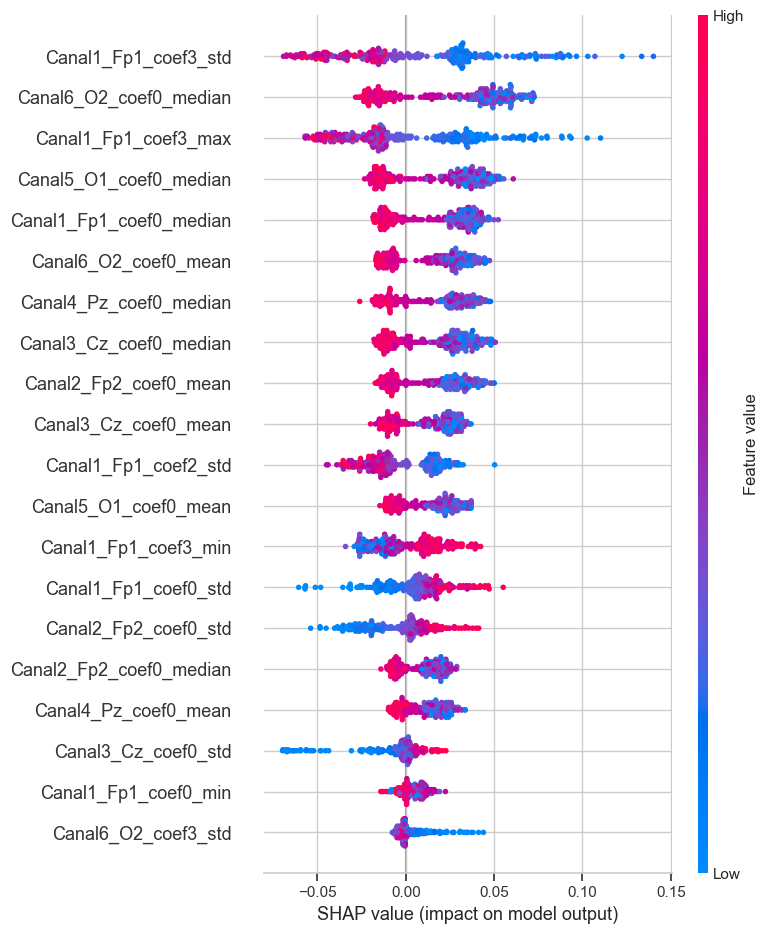

In [69]:
shap.summary_plot(shap_values_class1, X_test_feat, feature_names=feature_names, max_display=20)

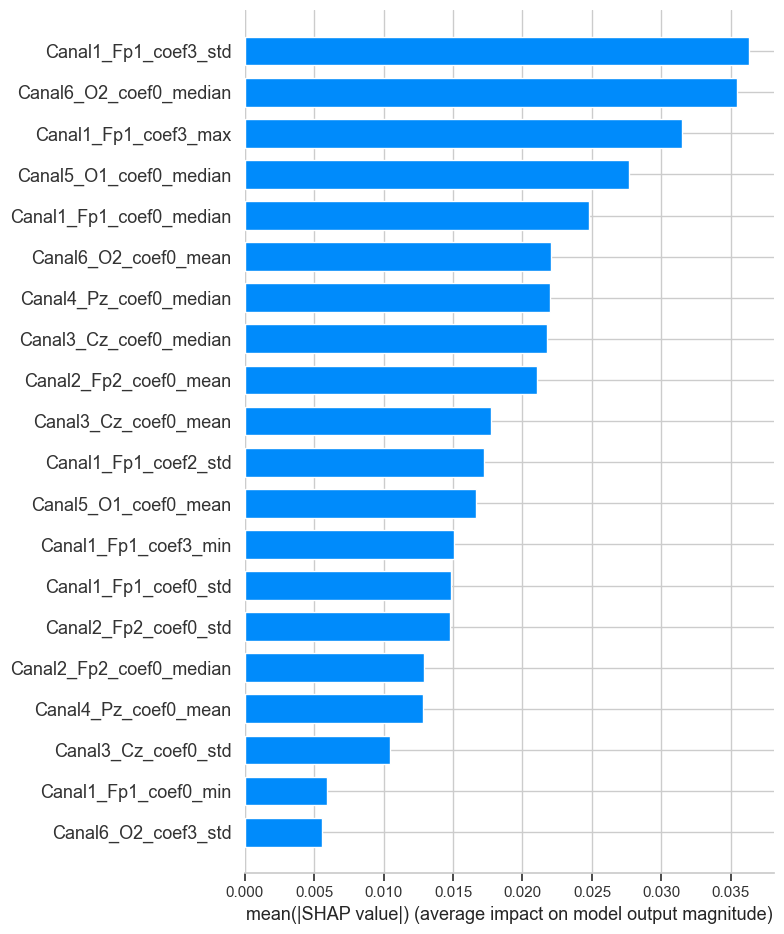

In [70]:
shap.summary_plot(shap_values_class1, X_test_feat, feature_names=feature_names, plot_type="bar", max_display=20)